# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import datetime
from imblearn.over_sampling import RandomOverSampler
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Assess data

### 1.1 Portfolio

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

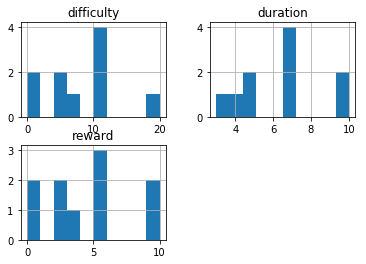

In [5]:
portfolio.hist();

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


### 1.2 Profile

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [9]:
profile = profile.dropna()
assert profile.isnull().sum().sum() == 0

In [10]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


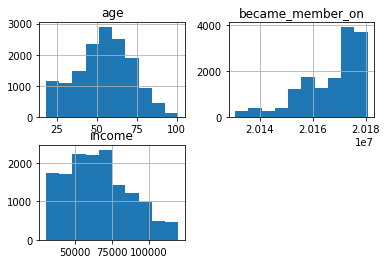

In [12]:
profile.hist();

### 1.3 Transcript

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

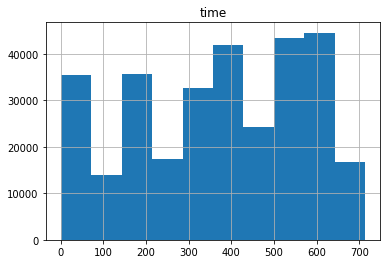

In [15]:
transcript.hist();

In [16]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


## 2. Data engineering

### 2.1 Portfolio

In [17]:
channels_full_list = ['email', 'mobile', 'social', 'web']
def transform_channels(channels):
    """Transform portfolio channels to bool values."""
    channels_bools = []
    for channel in channels_full_list:
        if channel in channels:
            channels_bools.append(1)
        else:
            channels_bools.append(0)
    return channels_bools

In [18]:
def engineer_portfolio(portfolio=portfolio):
    # Change name of column id to offer_id to be coherent with the transcript dataframe.
    portfolio['offer_id'] = portfolio['id']
    portfolio = portfolio.drop('id', axis=1)
    
    # Dummy the portfolio channels.
    portfolio[channels_full_list] = portfolio['channels'].apply(transform_channels).apply(pd.Series)
    portfolio = portfolio.drop('channels', axis=1)
    
    # Convert duration in hours.
    portfolio['duration_hours'] = portfolio['duration'].apply(lambda val: val*24)
    portfolio = portfolio.drop('duration', axis=1)
    
    # Dummy the offer_type.
    portfolio = pd.get_dummies(portfolio, columns=['offer_type'])
    
    return portfolio

In [19]:
portfolio_engineered_df = engineer_portfolio()

In [20]:
portfolio_engineered_df.head()

,difficulty,reward,offer_id,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,168,1,0,0
1,10,10,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120,1,0,0
2,0,0,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96,0,0,1
3,5,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168,1,0,0
4,20,5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,240,0,1,0


### 2.2 Profile

In [21]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [22]:
def extract_year_from_date(date):
    """Extract the year from a date in string format."""
    year = str(date)[:4]
    assert year in ['2013', '2014', '2015', '2016', '2017', '2018', '2019'], year
    return int(year)

In [23]:
def engineer_profile(profile=profile):
    """Data engineering on the profile Dataframe."""
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    profile['year'] = profile['became_member_on'].apply(extract_year_from_date)
    profile['weekday_membership'] = profile['became_member_on'].apply(lambda date: date.weekday())
    
    profile = pd.get_dummies(profile, prefix=['gender', 'became_member_on'], columns=['gender', 'year']).drop('became_member_on', axis=1)
    
    return profile

In [24]:
profile_engineered_df = engineer_profile()
profile_engineered_df.head()

,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,5,1,0,0,0,0,0,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1,0,0,0,0,0,0,1,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,3,0,1,0,0,0,0,0,0,1
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,4,0,1,0,0,0,0,0,0,1
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,5,0,1,0,0,0,0,0,1,0


### 2.3 Transcript

In [25]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
transcript_new = transcript[transcript['person'].isin(profile['id'])]
transcript_new.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [27]:
transcript_new['offer_id'] = transcript_new['value'].apply(lambda val: val.get('offer_id', val.get('offer id', np.nan)))

c:\users\benjamin\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
transcript_new.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [29]:
merged_transcript = transcript_new.merge(profile_engineered_df, left_on='person', right_on='id', how='left').drop('person', axis=1)

In [30]:
merged_transcript.head()

,event,time,value,offer_id,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1,0,0,0,0,0,0,1,0
1,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,68,e2127556f4f64592b11af22de27a7932,70000.0,3,0,1,0,0,0,0,0,0,1
2,offer received,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,65,389bc3fa690240e798340f5a15918d5c,53000.0,4,0,1,0,0,0,0,0,0,1
3,offer received,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,5,0,1,0,0,0,0,0,1,0
4,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,61,aa4862eba776480b8bb9c68455b8c2e1,57000.0,0,1,0,0,0,0,0,0,1,0


In [31]:
df = merged_transcript.merge(portfolio_engineered_df, on='offer_id', how='left').sort_values(by=['id', 'time']).reset_index(drop=True)

In [32]:
df.head(10)

,event,time,value,offer_id,age,id,income,weekday_membership,gender_F,gender_M,...,difficulty,reward,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
1,offer viewed,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
2,transaction,228,{'amount': 22.16},NaN,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
4,offer viewed,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
5,offer received,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,1.0,0.0,0.0
6,transaction,414,{'amount': 8.57},NaN,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,offer completed,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,1.0,0.0,0.0
8,offer viewed,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,1.0,0.0,0.0
9,offer received,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,10.0,2.0,1.0,1.0,1.0,1.0,240.0,0.0,1.0,0.0


We will have to treat the offers in two differents ways, depending on their type. For offers of type "informational", it is just an advertisement, so there is no "reward", nor a "difficulty". Also, for this type of offer, their is no "offer completed" event. 

Therefore, here are the steps necessary for the different offer types to be considered "successful": 

"BOGO" and "discount: 

    1. "offer received"
    2. "offer viewed"
    3. "offer completed"
    4. "transaction"
    
"informational":
    1. "offer received"
    2. "offer viewed"
    3. "transaction"

In [33]:
transcript_new.merge(portfolio, on='offer_id').groupby(['offer_type', 'event']).sum()

time  difficulty  duration  reward
offer_type    event                                                 
bogo          offer completed  5976720      111125     91980  111125
              offer received   8830488      199065    159421  199065
              offer viewed     7790010      171345    128995  171345
discount      offer completed  6988410      191062    145469   49416
              offer received   8861376      313935    226782   80161
              offer viewed     6547176      187623    155093   49946
informational offer received   4427088           0     46557       0
              offer viewed     3340554           0     31567       0

In [34]:
new_df = df.copy()

In [35]:
customer_ids = list(new_df['id'].unique())

In [36]:
groups = new_df.sort_values('time').groupby('id')
group2 = groups.get_group(customer_ids[1])

In [37]:
def is_offer_successfull(customer_df):
    """Checks if offers are successful for a given customer."""
    completed_with_success = False
    
    customer_successful_map = {}
    
    for idx, row in customer_df.iterrows():
        successful = 0
        if row.event == 'offer received':
            deadline = row.time + row.duration_hours
            next_row = new_df.loc[idx + 1]
            if next_row.event == 'offer viewed':
                next_next_row  = new_df.loc[idx + 2]
                if next_next_row.time <= row.time + deadline:
                    if row.offer_type_informational == 1:
                        if next_next_row.event == 'transaction':
                            successful = 1
                    else:
                        if next_next_row.event == 'offer completed' or next_next_row.event == 'transaction':
                            successful = 1
                            completed_with_success = True
                            
        if idx not in customer_successful_map:
            customer_successful_map[idx], customer_successful_map[idx + 1], customer_successful_map[idx + 2] = successful, successful, successful
            if completed_with_success:
                 customer_successful_map[idx + 3] = successful
    return customer_successful_map

In [38]:
group2

,event,time,value,offer_id,age,id,income,weekday_membership,gender_F,gender_M,...,difficulty,reward,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
20,offer received,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
21,offer viewed,6,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
22,transaction,132,{'amount': 13.49},NaN,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,offer received,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,7.0,3.0,1.0,1.0,1.0,1.0,168.0,0.0,1.0,0.0
24,offer viewed,186,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,7.0,3.0,1.0,1.0,1.0,1.0,168.0,0.0,1.0,0.0
26,offer completed,252,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,7.0,3.0,1.0,1.0,1.0,1.0,168.0,0.0,1.0,0.0
25,transaction,252,{'amount': 11.93},NaN,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,offer received,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
28,offer viewed,354,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
29,offer received,408,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,20.0,5.0,1.0,0.0,0.0,1.0,240.0,0.0,1.0,0.0


In [39]:
is_offer_successfull(group2)

{20: 0,
 21: 0,
 22: 0,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 0,
 36: 0,
 37: 0,
 38: 0}

In [40]:
successful_map = {}
new_df['successful_offer'] = np.nan
grouped_users = new_df.sort_values('time').groupby('id')
for customer, customer_df in grouped_users:
    customer_map = is_offer_successfull(customer_df)
    successful_map.update(customer_map)
new_df['successful_offer'] = new_df['successful_offer'].fillna(successful_map)

In [41]:
new_df['successful_offer'].value_counts()

0.0    225707
1.0     47055
Name: successful_offer, dtype: int64

In [42]:
new_df.shape

(272762, 28)

In [43]:
final_df = new_df.drop(['id', 'offer_id', 'value', 'time', 'event'], axis=1).dropna(axis=0).drop_duplicates(keep='first')

In [44]:
def save_dataframe_to_csv(df, filepath):
    """Save a given DataFrame in a csv file."""
    df.to_csv(path_or_buf=filepath, index=False)

In [45]:
save_dataframe_to_csv(final_df, 'data/cleaned_data.csv')

## 3. Data Analysis

In [46]:
successful_offers = final_df[final_df['successful_offer'] == 1]
percentage_of_success = len(successful_offers) / len(final_df)

print("The percentage of success for the different offers is {:.2f}%.".format(percentage_of_success * 100))

The percentage of success for the different offers is 21.62%.


In [47]:
def plot_successful_projects_prob(df, attribute, attribute_title, x_axis_title=None, palette="husl"):
    """Make a plot of the probability of success of a project for a specified attribute"""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    s = df.groupby(attribute)['successful_offer'].mean()
    df = pd.DataFrame({attribute: s.index, '% of success': s.values})
    p1 = sns.barplot(x=attribute, y='% of success', data=df, palette=palette)
    plt.xticks(rotation=45)
    ax.axhline(y=percentage_of_success, color='black').set_linestyle('--')
    p1.text(0, percentage_of_success + 0.003, "Mean % of success", horizontalalignment='left', size='medium', color='black')
    ax.set_title(f'Probability of success by {attribute_title}', fontsize=20)
    if x_axis_title: 
        ax.set_xlabel(x_axis_title.capitalize(), fontsize=15)
    else:
        ax.set_xlabel(attribute_title.capitalize(), fontsize=15)
    ax.set_ylabel("% of success", fontsize=15)

In [48]:
df_for_analysis = new_df.drop(['id', 'value', 'time', 'event'], axis=1).dropna(axis=0).drop_duplicates(keep='first').merge(portfolio, left_on='offer_id', right_on='id', how='inner').drop(['difficulty_x', 'reward_x'], axis=1).rename(columns={'difficulty_y': 'difficulty', 'reward_y': 'reward'})

In [49]:
save_dataframe_to_csv(df_for_analysis, 'data/data_for_analysis.csv')

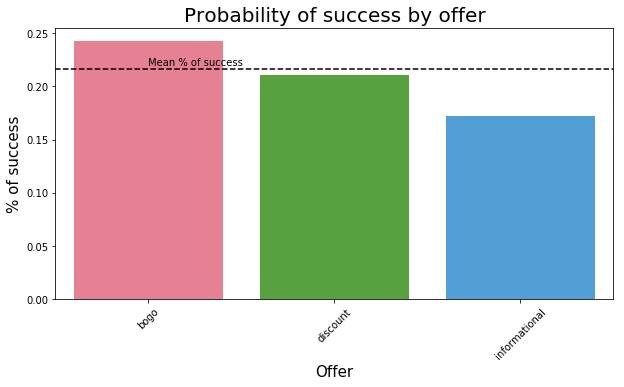

In [50]:
plot_successful_projects_prob(df=df_for_analysis, attribute='offer_type', attribute_title='offer')

As we can see from the graph above, the most sucessful offers are "BOGO", which stands for "Buy One Get One Free". That result was anticipated, since that kind of offer is very attractive for a customer because he receives a free item, whereas a "Discount" item only gives the customer a better price. Finally, the "Informational" offer type does not give any reward to the customer, so it was also anticipated that it would be the least sucessful offer type.

In [51]:
def age_interval(age):
    """Put age into an interval."""
    if age < 10:
        interval = '[0, 10['
    elif age >=10 and age < 20:
        interval = '[10, 20['
    elif age >=20 and age < 30:
        interval = '[20, 30['
    elif age >=30 and age < 40:
        interval = '[30, 40['
    elif age >=40 and age < 50:
        interval = '[40, 50['
    elif age >=50 and age < 60:
        interval = '[50, 60['
    elif age >=60 and age < 70:
        interval = '[60, 70['
    elif age >= 70:
        interval = '[70+, ]'
    else:
        raise ValueError(f"Unknow value for age : {age}")
    return interval   

In [52]:
df_for_analysis['age_interval'] = df_for_analysis['age'].apply(age_interval)

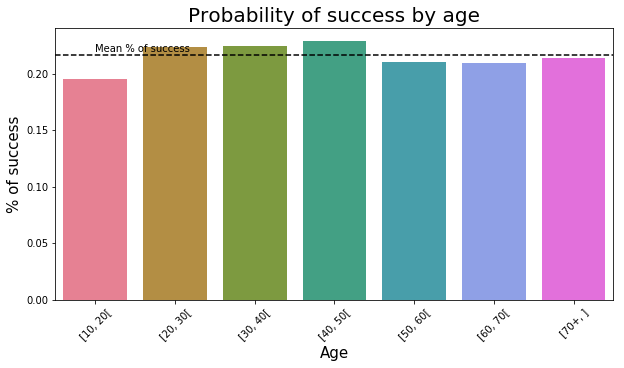

In [53]:
plot_successful_projects_prob(df=df_for_analysis, attribute='age_interval', attribute_title='age')

The results seen above are very interesting. Essentially, it means that the younger generation, as well as the oldest ones, are the least influenced by the different offer types. One way to analyze that result would be to say that those customers buy Starbucks products for very specific reason. Presumably, the oldest people would want ot buy a product to relax on a given day in a coffee shop, whereas the younger ones would buy want a drink to enjoy while shopping in a mall, or giving them energy before going to school. Therefore, those kind of customers would probably buy that coffee without any offer type. It would probably be a good strategy to limit the offers to those groups, especially the offers giving discounts or free items.

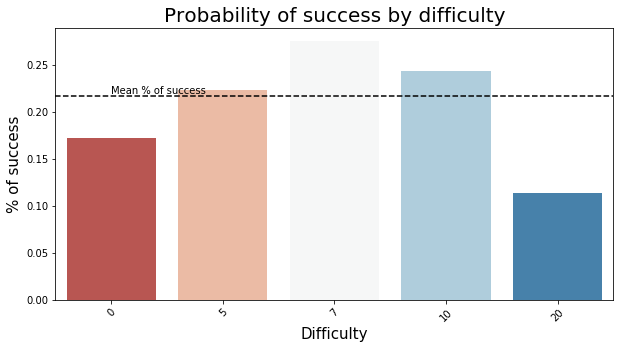

In [54]:
plot_successful_projects_prob(df=df_for_analysis, attribute='difficulty', attribute_title='difficulty', palette='RdBu')

From the graph above, we can see that the diffculty, i.e the amount the customer has to spend to compelte an offer, has an important effect on the probabilty of an offer to be completed. The offer asking for a purchase of 20$ or more are the least successful; they also only give a reward of 5, so for a customer that type of offer is not very benfecial, which explains why the prbability of success associated with it is so low. Also, the offers that have a difficulty of "0" are of type "Informational"; that offer type also give a reward of "0". We saw above that the "Infomational" offer types have the least chance of success. We can see that the most successful difficullty is "7". That kind of offer gives a reward of "3", so for a customer the balance between the amount he has to spend and the reward he received is interesting. The second most successful offer difficulty is "10", which gives a reward of "10" or "2". The reward of "10" is the offer type "Buy One Get One Free". We saw above that that kind of offer type has the highest probability of success. Those two difficulties, "7" and "10", are the only one above the mean percentage of success.

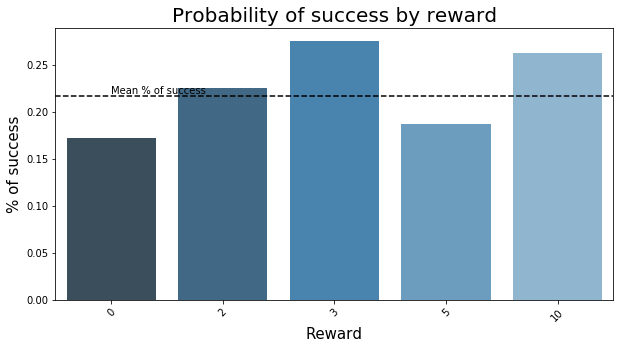

In [55]:
plot_successful_projects_prob(df=df_for_analysis, attribute='reward', attribute_title='reward', palette='Blues_d')

In relation with the previous graph, the offers that give a reward of "3" are the most successful, because they only require the user to spend 7$, so the balance between the two is beneficial for the customer. The offers that give a reward of "10", are the "Buy One Get One Free" offers, and we can see that they are the second most successful offers in the graph above. Finally, the offers that give a reward of "0" are the "Infomational" offer types, basically only an advertisment, so it was anticipated that those can of offers would be the ones having the least success.

In [56]:
def income_interval(income):
    """Put income into an interval."""
    income = income / 1000
    if income >= 30 and income < 40:
        interval = '[30, 40['
    elif income >= 40 and income < 50:
        interval = '[40, 50['
    elif income >= 50 and income < 60:
        interval = '[50, 60['
    elif income >= 60 and income < 70:
        interval = '[60, 70['
    elif income >= 70 and income < 80:
        interval = '[70, 80['
    elif income >= 80 and income < 90:
        interval = '[80, 90['
    elif income >= 90 and income < 100:
        interval = '[90, 100['
    elif income >= 100:
        interval = '[100+, ]'
    else:
        raise ValueError(f"Unknow value for income : {income}")
    return interval  

In [57]:
df_for_analysis['income_interval'] = df_for_analysis['income'].apply(income_interval)

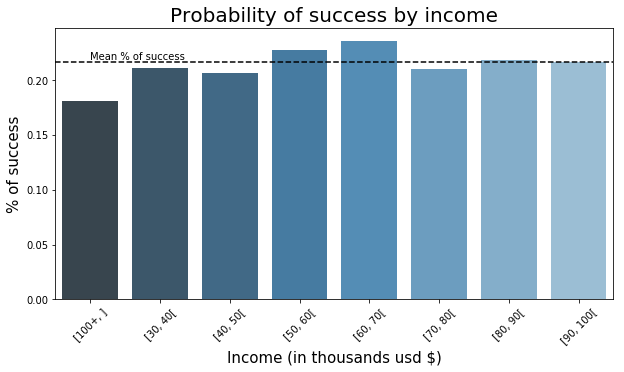

In [58]:
plot_successful_projects_prob(df=df_for_analysis, attribute='income_interval', attribute_title='income', x_axis_title='income (in thousands USD $)', palette='Blues_d')

Intersting finding from the graph above, the customers with incomes of 100K USD and more are the least influencable by offers. Presumably, those customers, having a lot of money, are not influences by any time of discount and would buy their Starbuck item regardless of the cicumstances. It would be a good idea to simply not send them any time of offer, or at least less often that the other groups of the population. The most influencable customers are making between 60 and 70 000 UDS per year. The interval just below, betwwen 50K and 60K, is also very influencable. 

## 4. Machine Learning

In [59]:
random_state = 42
np.random.seed(42)

In [60]:
X = final_df.drop(['successful_offer'], axis=1)
y = final_df['successful_offer'].astype(int)

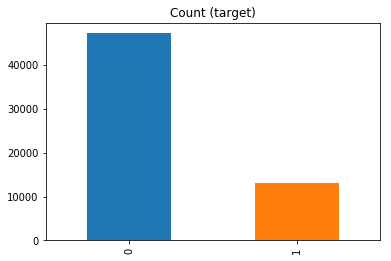

In [61]:
y.value_counts().plot(kind='bar', title='Count (target)');

In [66]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

34155 new random picked points


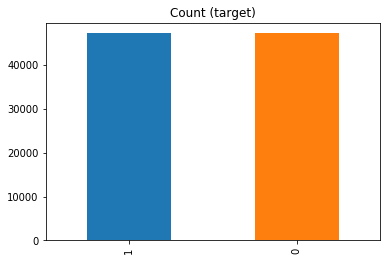

In [72]:
pd.Series(y_ros).value_counts().plot(kind='bar', title='Count (target)');

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.20, random_state=random_state)

In [74]:
def train_and_test_model(model, X_train, X_test, y_train, y_test, print_time=True):
    """Train and test a machine learning model"""
    start = time.time()
    model = model.fit(X_train, y_train)
    end = time.time()
    if print_time:
        print('The model took {:.2f} seconds to train.'.format(end - start))
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_accuracy = accuracy_score(train_predictions, y_train)
    test_accuracy = accuracy_score(test_predictions, y_test)
    
    print(f'The train accuracy of the model is {train_accuracy}')
    print(f'The test accuracy of the model is {test_accuracy}')
    
    return model

### 4.0 Dummy Model

In [75]:
dummy = DummyClassifier(strategy='constant', constant=0)
train_and_test_model(dummy, X_train, X_test, y_train, y_test, print_time=False);

The train accuracy of the model is 0.49875447197561945
The test accuracy of the model is 0.5049819800720797


### 4.1 Logistic Regression

In [76]:
lr = LogisticRegression(random_state=random_state, solver='liblinear');
train_and_test_model(lr, X_train, X_test, y_train, y_test);

The model took 2.01 seconds to train.
The train accuracy of the model is 0.592831588710746
The test accuracy of the model is 0.5890396438414246


### 4.2 Decision Tree

In [77]:
dt = DecisionTreeClassifier(random_state=random_state);
train_and_test_model(dt, X_train, X_test, y_train, y_test);

The model took 0.67 seconds to train.
The train accuracy of the model is 0.9413674307671923
The test accuracy of the model is 0.7775068899724401


### 4.3 Random Forest

In [78]:
rf = RandomForestClassifier(random_state=random_state, n_estimators=100);
train_and_test_model(rf, X_train, X_test, y_train, y_test);

The model took 17.13 seconds to train.
The train accuracy of the model is 0.9413541804690606
The test accuracy of the model is 0.8181577273690905


### 4.4 Gradient Boosting

In [79]:
gbc = GradientBoostingClassifier(random_state=random_state);
train_and_test_model(gbc, X_train, X_test, y_train, y_test);

The model took 17.74 seconds to train.
The train accuracy of the model is 0.6016562872664635
The test accuracy of the model is 0.5948696205215179


### 4.5 Adaboost

In [80]:
adc = AdaBoostClassifier(random_state=random_state);
train_and_test_model(adc, X_train, X_test, y_train, y_test);

The model took 6.20 seconds to train.
The train accuracy of the model is 0.5916788127732874
The test accuracy of the model is 0.5869196523213908


### 4.6 XGBoost

In [81]:
xg = XGBClassifier();
train_and_test_model(xg, X_train, X_test, y_train, y_test);

The model took 15.32 seconds to train.
The train accuracy of the model is 0.6021730488936001
The test accuracy of the model is 0.5949226203095188


As we can see above, the model taht performs the best is by far the Random Forest Classifier. However, it does overfitting, because its training accuracy is around 94%, and its testing accuracy is around 81%. We will do hyperparameters tuning to find a better model.

### 4.7 Hyperparameters Tuning

In [85]:
parameters = {'n_estimators': [50, 60, 70, 100, 200], 
              'min_samples_split':[3, 9, 15],
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth': [None, 1, 2, 3, 5, 7, 9],
              'random_state': [random_state],
              'n_jobs' : [-1]
             }
grid_object = GridSearchCV(rf, parameters, cv=3)
grid_object = train_and_test_model(grid_object, X_train, X_test, y_train, y_test, print_time=False);

The train accuracy of the model is 0.9405856631774215
The test accuracy of the model is 0.8122217511129955


In [86]:
best_model = grid_object.best_estimator_
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [87]:
feature_importances = best_model.feature_importances_

In [93]:
def feature_plot(importances, X, y_train, n_features):
    """Display the "n_features" most important features"""
    indices = np.argsort(importances)[::-1]
    columns = X.columns.values[indices[:n_features]]
    values = importances[indices][:n_features]

    fig = plt.figure(figsize=(9, 7))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize=16)
    plt.bar(np.arange(n_features), values, width=0.6, align="center", color='#00A000', label="Feature Weight")
    plt.bar(np.arange(n_features) - 0.3, np.cumsum(values), width=0.2, align="center", color='#00A0A0',
           label="Cumulative Feature Weight")
    plt.xticks(np.arange(n_features), columns, rotation=45)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize=12)
    plt.xlabel("Feature", fontsize=12)

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

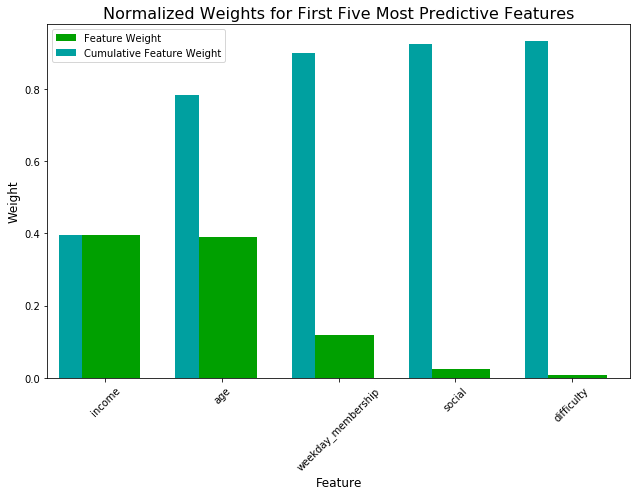

In [95]:
feature_plot(feature_importances, X, y_train, 5)

In [96]:
def save_model(model, model_filepath):
    """ Save the model as a pickle file. """
    with open(model_filepath, 'wb') as pickle_model:
        pickle.dump(model, pickle_model)

In [107]:
save_model(grid_object, 'models/classifier.pkl')

In [99]:
X_test[0].reshape(-1, 1).T.shape

(1, 22)

In [103]:
grid_object.predict(X_test[0].reshape(-1, 1).T)

array([1])

In [106]:
y_test[0]

1